# Detect disturbed tress

## Packages and Data

In [9]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import pandas as pd
import numpy as np
from utils.constants import spectral_bands, indices
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from scipy.stats import pointbiserialr
from utils.preprocessing import Preprocessing
from scipy.stats import linregress

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../../data/Trainings_Datensatz.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

df = Preprocessing.interpolate_b4(df, method="linear")

In [12]:
calculateindices = CalculateIndices()
df = calculateindices.add_all_indices(df)

## Calculate std deviation for every index column

1. Normalize columns so that those with higher ranges do not have a greater influence
2. Group by year and compute the mean of each index column
3. Compute the standard deviation of the yearly values
4. Join column "is_disturbed" to the resulting df

In [13]:
bands_and_indices = spectral_bands + indices

scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[bands_and_indices] = df.groupby("species")[bands_and_indices].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
) 
# normalization grouped by species because different species can have different ranges 

In [14]:
df_yearly = df_norm.groupby(["id", "year"])[bands_and_indices].mean().reset_index()
std_df = df_yearly.groupby("id")[bands_and_indices].std().reset_index()
std_df = std_df.rename(columns={col: f"{col}_stdv" for col in bands_and_indices})

df_disturbance = df.groupby("id")["is_disturbed"].first().reset_index()
std_df = std_df.merge(df_disturbance, on="id", how="left")

In [15]:
std_df

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,gndvi_stdv,wdvi_stdv,tndvi_stdv,savi_stdv,ipvi_stdv,mcari_stdv,reip_stdv,masvi2_stdv,dvi_stdv,is_disturbed
0,1,0.001443,0.002388,0.002022,0.002207,0.006962,0.008983,0.008581,0.008661,0.002837,...,0.004492,0.008265,0.003255,0.005164,0.005050,0.000174,0.000159,0.000059,0.007326,False
1,2,0.002638,0.004479,0.003646,0.004730,0.005678,0.007194,0.005216,0.007551,0.009846,...,0.011259,0.006677,0.010242,0.012420,0.012423,0.000398,0.000155,0.002494,0.005223,False
2,3,0.005808,0.007473,0.011374,0.013846,0.022905,0.024976,0.027478,0.027717,0.030973,...,0.029003,0.044712,0.041316,0.055254,0.055209,0.002571,0.000085,0.000064,0.048469,True
3,4,0.003046,0.007629,0.008592,0.011366,0.018492,0.020920,0.023722,0.021066,0.015042,...,0.009050,0.028927,0.014787,0.018295,0.018311,0.000663,0.000142,0.009052,0.018591,False
4,5,0.002885,0.004692,0.006805,0.007227,0.017081,0.017616,0.018928,0.017664,0.008911,...,0.019241,0.033850,0.023179,0.030034,0.030002,0.002147,0.000067,0.000033,0.039482,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28207,28208,0.002490,0.003957,0.005900,0.007598,0.009079,0.008313,0.008750,0.010352,0.010685,...,0.016005,0.015582,0.021057,0.025953,0.025927,0.001103,0.000076,0.000054,0.019025,False
28208,28209,0.007227,0.008205,0.013705,0.016075,0.012198,0.015518,0.014618,0.015827,0.043116,...,0.068358,0.026903,0.064027,0.089236,0.089233,0.001054,0.000701,0.006053,0.034537,True
28209,28210,0.001678,0.001161,0.003130,0.001578,0.004340,0.006149,0.006252,0.006839,0.005941,...,0.007609,0.011202,0.010657,0.014393,0.014378,0.000768,0.000047,0.000012,0.013326,False
28210,28211,0.002685,0.002356,0.004028,0.002783,0.006951,0.010522,0.009819,0.008603,0.012807,...,0.028686,0.014378,0.019028,0.030101,0.030090,0.001399,0.000487,0.001300,0.019665,False


## Calculate slope of yearly mean

In [16]:
slope_list_all = None

for col in bands_and_indices:
    slopes_per_feature = []
    for id_ in df_yearly["id"].unique():
        df_sub = df_yearly[df_yearly["id"] == id_]
        slope, intercept, r_value, p_value, std_err = linregress(df_sub["year"], df_sub[col])
        slopes_per_feature.append({"id": id_, f"{col}_slope": slope})
    
    slope_df = pd.DataFrame(slopes_per_feature)
    if slope_list_all is None:
        slope_list_all = slope_df
    else:
        slope_list_all = slope_list_all.merge(slope_df, on="id")

In [17]:
std_slope_df = std_df.merge(slope_list_all, on="id", how="left")

std_slope_df

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,ndvi_slope,gndvi_slope,wdvi_slope,tndvi_slope,savi_slope,ipvi_slope,mcari_slope,reip_slope,masvi2_slope,dvi_slope
0,1,0.001443,0.002388,0.002022,0.002207,0.006962,0.008983,0.008581,0.008661,0.002837,...,-0.001657,-0.002188,-0.002544,-0.001054,-0.001696,-0.001657,-0.000034,-0.000039,0.000023,-0.002282
1,2,0.002638,0.004479,0.003646,0.004730,0.005678,0.007194,0.005216,0.007551,0.009846,...,0.001441,0.001070,0.002870,0.001258,0.001442,0.001441,-0.000080,-0.000013,-0.000806,0.002240
2,3,0.005808,0.007473,0.011374,0.013846,0.022905,0.024976,0.027478,0.027717,0.030973,...,-0.008487,-0.005496,0.018602,-0.006870,-0.008487,-0.008487,0.000960,-0.000025,-0.000030,0.018101
3,4,0.003046,0.007629,0.008592,0.011366,0.018492,0.020920,0.023722,0.021066,0.015042,...,-0.007450,-0.002596,0.013322,-0.005928,-0.007442,-0.007450,-0.000057,-0.000015,-0.004100,0.008674
4,5,0.002885,0.004692,0.006805,0.007227,0.017081,0.017616,0.018928,0.017664,0.008911,...,-0.005623,-0.000448,-0.010529,-0.003660,-0.005630,-0.005623,-0.001078,0.000020,0.000006,-0.011740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28207,28208,0.002490,0.003957,0.005900,0.007598,0.009079,0.008313,0.008750,0.010352,0.010685,...,0.003013,0.000160,0.002687,0.003052,0.003016,0.003013,0.000259,-0.000030,-0.000021,0.001236
28208,28209,0.007227,0.008205,0.013705,0.016075,0.012198,0.015518,0.014618,0.015827,0.043116,...,-0.044729,-0.033656,-0.010395,-0.032090,-0.044730,-0.044729,-0.000508,-0.000339,0.002036,-0.015900
28209,28210,0.001678,0.001161,0.003130,0.001578,0.004340,0.006149,0.006252,0.006839,0.005941,...,-0.001693,-0.001259,-0.000345,-0.001347,-0.001695,-0.001693,-0.000104,0.000002,0.000001,-0.000579
28210,28211,0.002685,0.002356,0.004028,0.002783,0.006951,0.010522,0.009819,0.008603,0.012807,...,-0.008685,-0.008949,-0.004193,-0.005434,-0.008688,-0.008685,-0.000386,-0.000212,0.000375,-0.005745


## Correlation between features and disturbance

In [18]:
correlations = []

for col in [c for c in std_slope_df.columns if c.endswith("_stdv") or c.endswith("_slope")]:
    r, p = pointbiserialr(std_slope_df["is_disturbed"].astype(int), std_slope_df[col])
    correlations.append({"feature": col, "correlation": r, "p_value": p})

correlations = pd.DataFrame(correlations).sort_values(by="correlation", ascending=False)

correlations

,feature,correlation,p_value
28,b11_slope,0.531285,0.000000e+00
23,b5_slope,0.528492,0.000000e+00
8,b11_stdv,0.517996,0.000000e+00
11,gndvi_stdv,0.514982,0.000000e+00
3,b5_stdv,0.501880,0.000000e+00
20,b2_slope,0.492893,0.000000e+00
15,ipvi_stdv,0.487777,0.000000e+00
10,ndvi_stdv,0.487777,0.000000e+00
14,savi_stdv,0.486328,0.000000e+00
21,b3_slope,0.467523,0.000000e+00


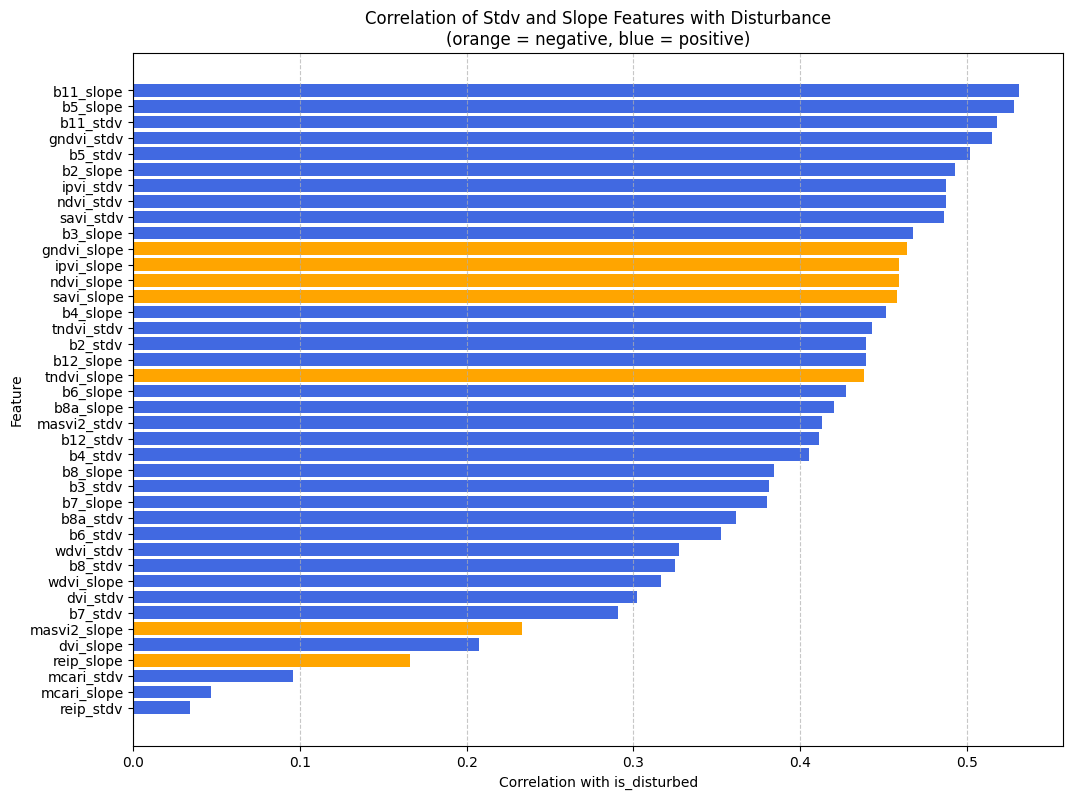

In [19]:
correlations["abs_corr"] = correlations["correlation"].abs()

correlations_df_to_plot = correlations.sort_values(by="abs_corr", ascending=True)
colors = ["orange" if val < 0 else "royalblue" for val in correlations_df_to_plot["correlation"]]

plt.figure(figsize=(12, 9))
plt.barh(
    correlations_df_to_plot["feature"],
    correlations_df_to_plot["abs_corr"],
    color=colors
)

plt.xlabel("Correlation with is_disturbed")
plt.ylabel("Feature")
plt.title("Correlation of Stdv and Slope Features with Disturbance\n(orange = negative, blue = positive)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

## Analysis stdv & slope of indices 

In [ ]:
col = "b11_slope"
std_slope_df[~std_slope_df["is_disturbed"]].sort_values(col, ascending=False)

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,ndvi_slope,gndvi_slope,wdvi_slope,tndvi_slope,savi_slope,ipvi_slope,mcari_slope,reip_slope,masvi2_slope,dvi_slope
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.078245,-0.031921,-0.020929,-0.066923,-0.078240,-0.078245,-0.000389,-0.000026,0.000955,-0.029214
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,-0.050821,-0.035574,0.005197,-0.034770,-0.050812,-0.050821,-0.000337,-0.000531,-0.000998,0.000147
26201,26202,0.013934,0.016201,0.027229,0.025218,0.014909,0.014042,0.016933,0.016095,0.109507,...,-0.049133,-0.035149,0.006116,-0.033149,-0.049112,-0.049133,-0.000436,-0.000431,-0.002051,0.001690
6176,6177,0.013941,0.016781,0.026801,0.025058,0.017302,0.016253,0.019201,0.018143,0.107465,...,-0.051819,-0.038116,0.006033,-0.034884,-0.051807,-0.051819,-0.000317,-0.000495,-0.001231,0.001570
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,-0.056070,-0.039993,0.005557,-0.037962,-0.056059,-0.056070,-0.000495,-0.000349,-0.001196,0.000358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19972,19973,0.004048,0.009329,0.012597,0.016100,0.031562,0.034840,0.043284,0.037841,0.032613,...,0.014389,0.010834,-0.002486,0.011874,0.014387,0.014389,-0.000146,0.000306,0.000100,0.000149
22319,22320,0.012512,0.014623,0.011250,0.016384,0.033185,0.037978,0.041252,0.037826,0.042537,...,0.000370,0.002990,-0.019970,0.000225,0.000366,0.000370,-0.000802,-0.000004,0.000564,-0.022735
14016,14017,0.031947,0.048587,0.061931,0.059145,0.054104,0.051903,0.054228,0.049897,0.048233,...,0.012039,0.011747,-0.019964,0.011382,0.012051,0.012039,0.000214,0.000054,0.000044,-0.001969
17513,17514,0.121576,0.119378,0.118368,0.117796,0.107294,0.103265,0.104693,0.099919,0.103603,...,0.012753,0.012817,-0.029082,0.010928,0.012766,0.012753,0.000216,-0.000017,0.000012,0.002351


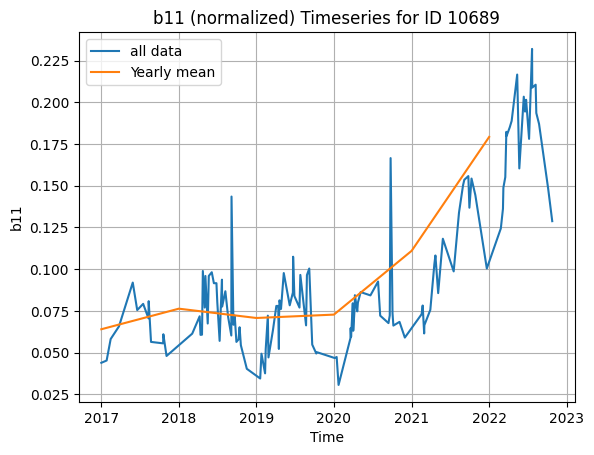

In [53]:
def plot_timeseries_oneid(id, col, yearly_mean = True):

    df_sub = df_norm[df_norm["id"] == id]

    plt.plot(df_sub["time"], df_sub[col], label="all data")

    if yearly_mean: 
        df_yearly_sub = df_yearly[df_yearly["id"] == id].copy()
        df_yearly_sub["year_dt"] = pd.to_datetime(df_yearly_sub["year"].astype(str) + "-01-01")
        plt.plot(df_yearly_sub["year_dt"], df_yearly_sub[col], label="Yearly mean")

    plt.title(f"{col} (normalized) Timeseries for ID {id}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_timeseries_oneid(10689, col)

## Model to detect mislabeled trees

### Build training data from data with presumably correctly labeled data

In [113]:
disturbed_df = std_slope_df[std_slope_df["is_disturbed"]].copy()
healthy_df = std_slope_df[~std_slope_df["is_disturbed"]].copy()

In [115]:
top_features = ["b11_slope", "b5_slope", "b11_stdv", "gndvi_stdv"]
healthy_df["combi_top_features"] = healthy_df[top_features].mean(axis=1)
healthy_df.sort_values(by="combi_top_features")

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,gndvi_slope,wdvi_slope,tndvi_slope,savi_slope,ipvi_slope,mcari_slope,reip_slope,masvi2_slope,dvi_slope,combi_top_features
12043,12044,0.003088,0.003261,0.007149,0.005418,0.006134,0.006345,0.007030,0.005714,0.003331,...,-0.000440,-0.002746,0.005097,0.005741,0.005737,0.000145,0.000027,2.150445e-05,-0.000048,0.000652
10951,10952,0.022716,0.022592,0.024803,0.019423,0.016529,0.015527,0.019662,0.016593,0.011202,...,0.001463,-0.007976,0.000282,0.000224,0.000224,0.000288,-0.000072,8.544732e-06,0.001284,0.000733
15155,15156,0.000397,0.001539,0.000668,0.001931,0.006208,0.007066,0.006467,0.007664,0.001977,...,0.000844,-0.001839,-0.001408,-0.002077,-0.002032,-0.000129,0.000073,9.736842e-06,-0.001759,0.000735
23144,23145,0.000601,0.000953,0.000389,0.000911,0.002480,0.002882,0.002695,0.003387,0.000899,...,0.000591,0.000476,0.000341,0.000537,0.000525,-0.000027,0.000009,-9.213511e-07,0.000469,0.000760
17446,17447,0.002315,0.002662,0.002019,0.001949,0.003682,0.003114,0.003856,0.003112,0.000826,...,-0.000166,-0.001981,-0.002279,-0.002378,-0.002376,-0.000022,0.000012,2.032380e-05,-0.001582,0.000821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,24991,0.014754,0.017541,0.028682,0.025342,0.017278,0.016097,0.018597,0.017729,0.106960,...,-0.040177,0.005699,-0.036920,-0.054713,-0.054724,-0.000499,-0.000347,-1.174447e-03,0.000714,0.062107
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.031921,-0.020929,-0.066923,-0.078240,-0.078245,-0.000389,-0.000026,9.549713e-04,-0.029214,0.062299
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,-0.039993,0.005557,-0.037962,-0.056059,-0.056070,-0.000495,-0.000349,-1.196120e-03,0.000358,0.062560
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,-0.035574,0.005197,-0.034770,-0.050812,-0.050821,-0.000337,-0.000531,-9.984114e-04,0.000147,0.062853


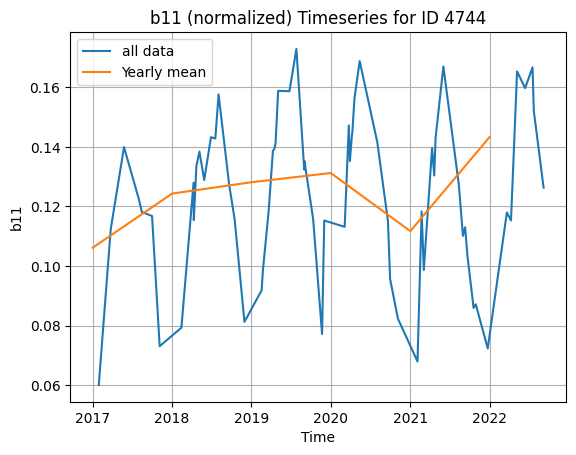

In [107]:
plot_timeseries_oneid(4744 , col)

- Idea: Healthy df with 10,000 data points that are almost certainly not disturbed
- the four top features must have a low value

- Testing of random samples showed that the first 20,000 rows of healthy_df should not be disturbed trees.

In [116]:
healthy_df_sub = healthy_df.sort_values(by="combi_top_features").head(20000).sample(n=10000, random_state=42)

train_df = pd.concat([disturbed_df, healthy_df_sub]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Disturbed:", len(disturbed_df))
print("Healthy (balanced):", len(healthy_df_sub))
print("Training set total:", len(train_df))

Disturbed: 3630
Healthy (balanced): 10000
Training set total: 13630


### Train ML-Models to predict disturbance  

In [109]:
feature_cols = [c for c in train_df.columns if c.endswith("_stdv") or c.endswith("_slope")]

X = train_df[feature_cols]
y = train_df["is_disturbed"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [110]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[2996    4]
 [ 120  969]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3000
           1       1.00      0.89      0.94      1089

    accuracy                           0.97      4089
   macro avg       0.98      0.94      0.96      4089
weighted avg       0.97      0.97      0.97      4089



In [111]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# xgboost has better result than random forest classifier

Confusion Matrix:
[[2986   14]
 [  71 1018]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3000
           1       0.99      0.93      0.96      1089

    accuracy                           0.98      4089
   macro avg       0.98      0.97      0.97      4089
weighted avg       0.98      0.98      0.98      4089



### Apply model to detect mislabeled trees

In [ ]:
# tbd